# Joint Travel Times

It's easy to find a driving time calculator online, where you can find how long it takes to drive to a destination for any point in a map region. But what if you're optimizing on the shortest distance for two people to get to work?

In this notebook, I demonstrate how to use OpenStreetMap data and transit time estimates to make a simple heatmap to identify optimal regions to hunt for housing to minimize ideal commuting time.

For this simple example, I'll only produce driving time estimates. This can be extended using tools such as the Google Maps API to also produce estimates for public transit.


In [1]:
import numpy as np
import pandas as pd
import osmnx as ox

import matplotlib.pyplot as plt

## Step 1: Building Blocks

Start off by just building the graph and getting drive time between two points. This will then form the basis of the next steps.

In [91]:
def get_transit_time(G,origin,destination):
    """
    Calculates transit time in minutes from origin to destination.
    
    Parameters:
        G: Graph
        origin: coordinates
        destination: coordinates
        
    Returns:
        travel_time in minutes
    
    """
    
    origin_node = ox.distance.nearest_nodes(G, origin[1], origin[0])
    destination_node = ox.distance.nearest_nodes(G, destination[1], destination[0])
    
    route = ox.shortest_path(G, origin_node, destination_node, weight="travel_time")
    
    min_travel_time = np.inf
    min_travel_node = None
    
    travel_time = sum(ox.utils_graph.get_route_edge_attributes(G,route,'travel_time'))
        
    return travel_time/60. # Returns travel time in minutes


def get_transit_time_onode(G,origin_node,destination):
    """
    Calculates transit time in minutes from origin to destination.
    
    Parameters:
        G: Graph
        origin_node: Node ID for starting point
        destination: coordinates
        
    Returns:
        travel_time in minutes
    
    """
    
    destination_node = ox.distance.nearest_nodes(G, destination[1], destination[0])
    
    route = ox.shortest_path(G, origin_node, destination_node, weight="travel_time")
    
    min_travel_time = np.inf
    min_travel_node = None
    
    try:
        travel_time = sum(ox.utils_graph.get_route_edge_attributes(G,route,'travel_time'))
        return travel_time/60. # Returns travel time in minutes

    except:
        # Error, likely route not found.
        return 90 # dummy value to make clear it's not workable

vget_transit_time_onode = np.vectorize(get_transit_time_onode,excluded=set([0,2]))

In [111]:
san_fran = ox.geocoder.geocode("San Francisco, CA")
foster_city = ox.geocoder.geocode("Foster City, CA")

origin=san_fran
destination=foster_city

location_point = tuple(np.array([origin, destination]).mean(0))

# The big overhead is in determining the initial graph. Then finding routes in it is straightforward.
new_graph=True

if new_graph:
    G = ox.graph_from_point(location_point, dist=30000, truncate_by_edge=True, network_type='drive') 
    G = ox.speed.add_edge_speeds(G, hwy_speeds = 100)
    G = ox.speed.add_edge_travel_times(G)
    ox.io.save_graphml(G,'san-francisco-30km-graph.gml')
    
else:
    G = ox.io.load_graphml('san-francisco-20km-graph.gml') #30km graph also on file
    

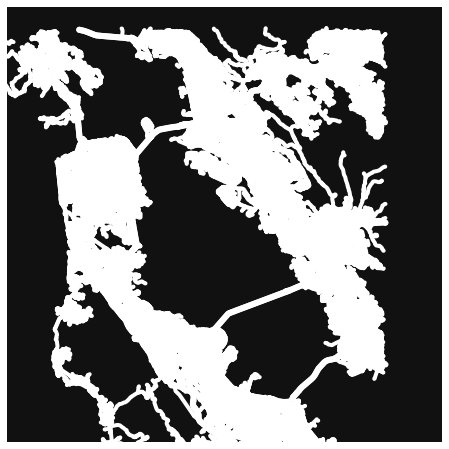

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [113]:
ox.plot.plot_figure_ground(G,dist=30000)

In [114]:
transit_time_sf_foster_city = get_transit_time(G,san_fran,foster_city)
print(f'Travel time from San Francisco to Foster City is estimated at {transit_time_sf_foster_city} minutes')

<class 'int'>
Travel time from San Francisco to Foster City is estimated at 22.77833333333334 minutes


## Step 2: Building the surface

Now that we've proven we can get drive times between two locations using osmnx, we can now generalize this to produce the surface of interest. The goal is to plot this surface in folium somehow and then this is a usable mapping product.

In [115]:
# 1. Sample a set of well-spaced nodes in the graph

full_node_list = [x for x in G.nodes(data=True)]
node_list = full_node_list[::100]

In [121]:
node_x = [node[1]['x'] for node in G.nodes(data=True)][::75]
node_y = [node[1]['y'] for node in G.nodes(data=True)][::75]

In [122]:
len(node_x) # Get a sense of how long this is going to take, adjust above accordingly.

944

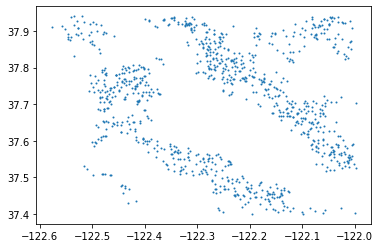

In [123]:
plt.figure()

plt.scatter(node_x,node_y,s=1)

plt.show()

In [124]:
node_array = np.array([x[0] for x in list(G.nodes(data=True))[::75]])

In [125]:
# 1.2. Look at some sample points

In [126]:
node_sf_time = vget_transit_time_onode(G,node_array,san_fran)

In [127]:
node_fc_time = vget_transit_time_onode(G,node_array,foster_city)

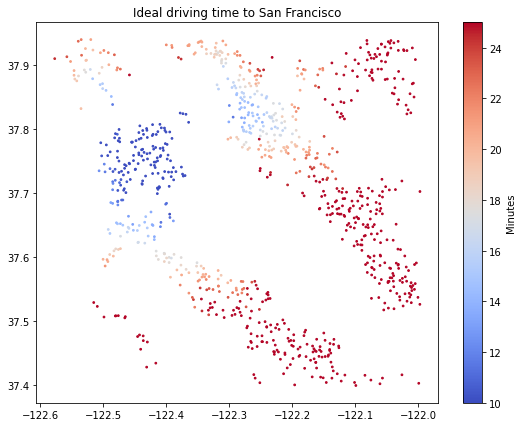

In [132]:
plt.figure(figsize=(9,7))

plt.scatter(node_x,node_y,c=node_sf_time,cmap='coolwarm',s=3,vmin=10,vmax=25)

plt.title('Ideal driving time to San Francisco')

c=plt.colorbar(label='Minutes')

plt.show()

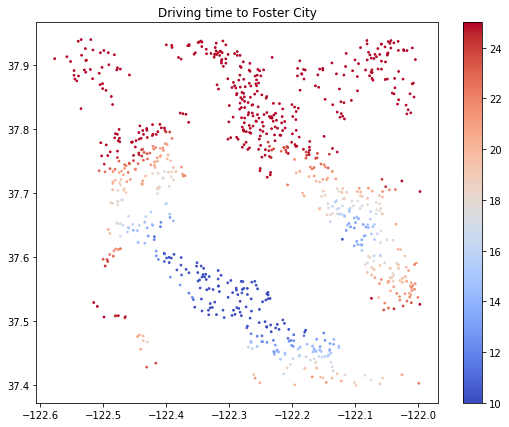

In [131]:
plt.figure(figsize=(9,7))

plt.scatter(node_x,node_y,c=node_fc_time,cmap='coolwarm',s=3,vmin=10,vmax=25)

plt.title('Driving time to Foster City')

c=plt.colorbar()

plt.show()

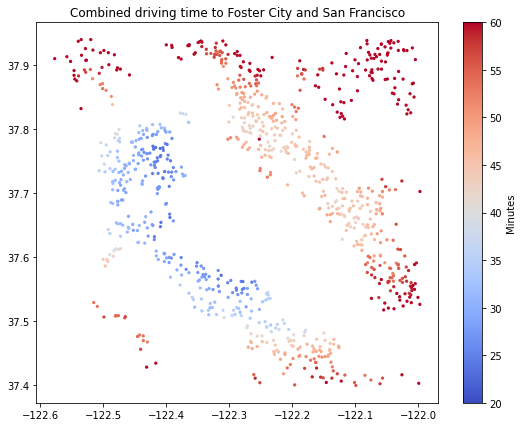

In [137]:
plt.figure(figsize=(9,7))

plt.scatter(node_x,node_y,c=node_fc_time + node_sf_time,cmap='coolwarm',s=5,vmin=20,vmax=60)

plt.title('Combined driving time to Foster City and San Francisco')

c=plt.colorbar(label='Minutes')

plt.show()

Extension: KDE it and get an interpolated surface. This would give it more of a heatmap style feel, although enforcing edges may be a challenge. 

The real goal should be to get this into Folium and at least plot on a map baselayer.